## Q1

Tổng số luật tìm được ban đầu: 1794 luật
Đã chọn Top-200 luật.
------------------------------

=== BẢNG MINH CHỨNG: 10 LUẬT TIÊU BIỂU ===


,antecedents_str,consequents_str,support,confidence,lift
1,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010932,0.951691,74.567045
2,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010599,0.955000,74.502403
3,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,0.010432,0.940000,74.297105
4,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010932,0.951691,74.244244
5,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010710,0.950739,74.169983
6,"HERB MARKER BASIL, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010710,0.936893,73.407619
7,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010599,0.931707,73.001294
8,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER PARSLEY,0.010488,0.921951,72.870539
9,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER PARSLEY,0.010377,0.921182,72.809761
10,HERB MARKER CHIVES,HERB MARKER PARSLEY,0.010377,0.921182,72.809761



[OK] Đã lưu bảng dạng ảnh tại: bang_minh_chung_luat.png
Bạn có thể tải file này về để chèn vào báo cáo.


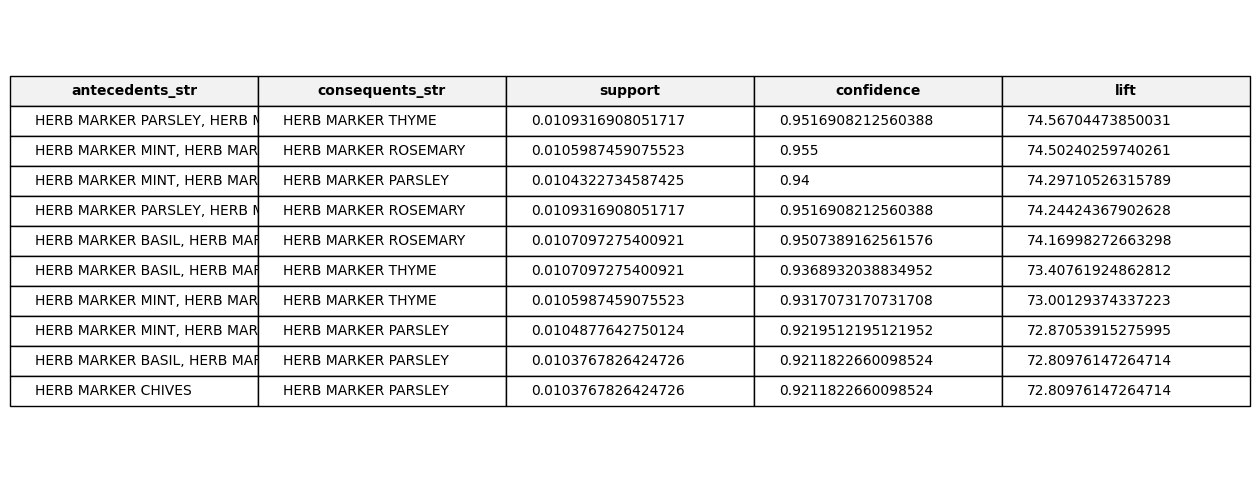

In [8]:
import pandas as pd
import matplotlib.pyplot as plt # Thêm thư viện vẽ hình

# 1. Cấu hình
RULES_PATH = "../data/processed/rules_apriori_filtered.csv" 
TOP_K = 200            
SORT_METRIC = "lift"   

# 2. Đọc file
try:
    rules = pd.read_csv(RULES_PATH)
    print(f"Tổng số luật tìm được ban đầu: {len(rules)} luật")
    
    # 3. Sắp xếp và lấy Top-K
    top_rules = rules.sort_values(by=SORT_METRIC, ascending=False).head(TOP_K)
    print(f"Đã chọn Top-{TOP_K} luật.")
    print("-" * 30)

    # 4. Trích xuất bảng 10 luật tiêu biểu
    display_cols = ['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']
    proof_table = top_rules.head(10)[display_cols].reset_index(drop=True)
    proof_table.index += 1 
    
    # Hiển thị trên màn hình để kiểm tra
    print(f"\n=== BẢNG MINH CHỨNG: 10 LUẬT TIÊU BIỂU ===")
    display(proof_table)

    # --- PHẦN CODE MỚI: LƯU BẢNG THÀNH ẢNH ---
    
    # Tạo một khung hình (Figure) kích thước lớn
    fig, ax = plt.subplots(figsize=(16, 6)) 
    
    # Tắt trục tọa độ (axis) để chỉ hiện bảng
    ax.axis('tight')
    ax.axis('off')
    
    # Vẽ bảng
    the_table = ax.table(cellText=proof_table.values,
                         colLabels=proof_table.columns,
                         loc='center',
                         cellLoc='left') # Căn lề trái cho dễ đọc text dài
    
    # Định dạng bảng cho đẹp
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1, 1.8) # Tăng chiều cao dòng (1.8) cho thoáng
    
    # Tô đậm tiêu đề cột (Header)
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#f2f2f2') # Màu nền xám nhẹ cho tiêu đề

    # Lưu file ảnh
    output_img_path = "bang_minh_chung_luat.png"
    plt.savefig(output_img_path, bbox_inches='tight', dpi=300)
    print(f"\n[OK] Đã lưu bảng dạng ảnh tại: {output_img_path}")
    print("Bạn có thể tải file này về để chèn vào báo cáo.")
    
    plt.show() # Hiển thị ảnh ra notebook

except FileNotFoundError:
    print("Lỗi: Không tìm thấy file luật. Hãy kiểm tra đường dẫn ../data/processed/...")

# Q2 : Tạo 2 biến thể 
## Với Biến thể Baseline:
* Nhóm sử dụng đặc trưng nhị phân (Binary): Nếu khách hàng mua đủ các sản phẩm trong vế trái của luật, giá trị là 1, ngược lại là 0.
Không sử dụng thông tin RFM.
## Với Biến thể Advanced:
* Trọng số (Weighting): Nhóm em sử dụng chỉ số Lift của luật làm giá trị đặc trưng thay vì số 1. Điều này giúp mô hình phân cụm nhận diện được mức độ "mặn mà" của khách hàng với nhóm sản phẩm đó (Lift càng cao, tín hiệu sở thích càng mạnh).
* Kết hợp RFM: Nhóm em ghép thêm 3 cột Recency, Frequency, Monetary để bổ sung thông tin về giá trị khách hàng.
* Chuẩn hóa (Scaling): Đây là bước bắt buộc. Nhóm em sử dụng StandardScaler cho 3 cột RFM để đưa về phân phối chuẩn (mean=0, std=1), đảm bảo cột Monetary (có giá trị hàng nghìn) không lấn át các cột đặc trưng luật (có giá trị nhỏ khoảng 10-100).

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

DATA_PATH = "../data/processed/cleaned_uk_data.csv"
RULES_PATH = "../data/processed/rules_apriori_filtered.csv" 
class ClusteringFeatureEngineer:
    def __init__(self, data_path, rules_path):
        print(f"Loading data from {data_path}...")
        self.df = pd.read_csv(data_path, parse_dates=['InvoiceDate'])
        
        print(f"Loading rules from {rules_path}...")
        self.rules = pd.read_csv(rules_path)
        
        # Tạo ma trận Customer-Item (dùng để check luật)
        print("Building Customer-Item Matrix...")
        self.cust_item_matrix = self.df.groupby(['CustomerID', 'Description'])['Quantity'].sum().unstack().fillna(0)
        self.cust_item_matrix = (self.cust_item_matrix > 0).astype(int)
        self.customer_ids = self.cust_item_matrix.index
        
        # Tính toán RFM (cho biến thể Advanced)
        print("Calculating RFM...")
        last_date = self.df['InvoiceDate'].max() + pd.Timedelta(days=1)
        self.rfm = self.df.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: (last_date - x.max()).days,
            'InvoiceNo': 'nunique',
            'TotalPrice': 'sum'
        }).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

    def _build_rule_features(self, top_k, sort_by, weight_metric, min_ant_len):
        """
        Hàm nội bộ để tạo đặc trưng từ luật
        """
        # 1. Lọc và Sắp xếp luật
        # Parse antecedents từ chuỗi string "{'A', 'B'}" thành list ['A', 'B']
        # Lưu ý: Cần xử lý cẩn thận chuỗi string set
        selected_rules = self.rules.copy()
        selected_rules['antecedents_list'] = selected_rules['antecedents'].apply(lambda x: list(eval(x)))
        selected_rules['ant_len'] = selected_rules['antecedents_list'].apply(len)
        
        # Lọc theo độ dài antecedent (Yêu cầu khuyến khích)
        valid_rules = selected_rules[selected_rules['ant_len'] >= min_ant_len]
        
        # Lấy Top-K
        top_rules = valid_rules.sort_values(by=sort_by, ascending=False).head(top_k)
        print(f"   -> Selected Top-{top_k} rules (Sorted by {sort_by}, Min Len={min_ant_len})")

        # 2. Map luật vào khách hàng
        rule_features = pd.DataFrame(index=self.customer_ids)
        
        # Duyệt qua từng luật để tạo cột feature
        for idx, row in top_rules.iterrows():
            ants = row['antecedents_list']
            # Kiểm tra khách có mua hết các món trong antecedents không
            try:
                # Lấy các cột sản phẩm tương ứng
                cols = self.cust_item_matrix[ants]
                # Nếu tổng hàng ngang == số lượng sản phẩm -> Đã mua đủ
                mask = (cols.sum(axis=1) == len(ants))
                
                if weight_metric is None:
                    # BASELINE: Nhị phân (0 hoặc 1)
                    rule_features[f'Rule_{idx}'] = mask.astype(int)
                else:
                    # ADVANCED: Gán trọng số (ví dụ Lift)
                    weight = row[weight_metric]
                    rule_features[f'Rule_{idx}'] = np.where(mask, weight, 0)
            except KeyError:
                continue # Bỏ qua nếu sản phẩm không khớp tên
                
        return rule_features.fillna(0)

    def create_baseline_dataset(self, top_k=50):
        """
        Tạo Biến thể 1: Baseline (Chỉ luật, Nhị phân 0/1)
        """
        print("\n=== GENERATING BASELINE VARIANT ===")
        print("Settings: Weighting=None (Binary), RFM=False")
        
        X = self._build_rule_features(top_k=top_k, sort_by='lift', weight_metric=None, min_ant_len=1)
        print(f"Baseline shape: {X.shape}")
        return X

    def create_advanced_dataset(self, top_k=50, weight_metric='lift', use_rfm=True):
        """
        Tạo Biến thể 2: Advanced (Luật có trọng số + RFM + Scale)
        """
        print("\n=== GENERATING ADVANCED VARIANT ===")
        print(f"Settings: Weighting={weight_metric}, RFM={use_rfm}, Scaling=True")
        
        # 1. Tạo Rule Features (Weighted)
        X_rules = self._build_rule_features(top_k=top_k, sort_by='lift', weight_metric=weight_metric, min_ant_len=1)
        
        if use_rfm:
            # 2. Ghép RFM
            X_final = X_rules.join(self.rfm, how='inner')
            
            # 3. Scale RFM (Bắt buộc để Monetary không lấn át Rule)
            scaler = StandardScaler()
            rfm_cols = ['Recency', 'Frequency', 'Monetary']
            print("   -> Scaling RFM columns with StandardScaler...")
            X_final[rfm_cols] = scaler.fit_transform(X_final[rfm_cols])
        else:
            X_final = X_rules
            
        print(f"Advanced shape: {X_final.shape}")
        return X_final


# Khởi tạo
engineer = ClusteringFeatureEngineer(DATA_PATH, RULES_PATH)

# --- BIẾN THỂ 1: BASELINE ---
# Yêu cầu: "sử dụng đặc trưng nhị phân theo luật"
X_baseline = engineer.create_baseline_dataset(top_k=50)

# --- BIẾN THỂ 2: NÂNG CAO ---
# Yêu cầu: "Đưa trọng số (lift)... Ghép thêm RFM... Scale RFM"
X_advanced = engineer.create_advanced_dataset(
    top_k=50,             # Giữ nguyên số luật để so sánh công bằng
    weight_metric='lift', # Dùng Lift làm trọng số
    use_rfm=True          # Ghép thêm RFM
)

# Lưu kết quả để dùng cho bước Phân cụm (K-Means)
print("\n=== SAVING DATASETS ===")
X_baseline.to_csv("../data/processed/X_baseline.csv")
X_advanced.to_csv("../data/processed/X_advanced.csv")
print("Done! Files saved to data/processed/")

Loading data from ../data/processed/cleaned_uk_data.csv...


C:\Users\Mr Vinh\AppData\Local\Temp\ipykernel_28736\3174951071.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(data_path, parse_dates=['InvoiceDate'])


Loading rules from ../data/processed/rules_apriori_filtered.csv...
Building Customer-Item Matrix...
Calculating RFM...

=== GENERATING BASELINE VARIANT ===
Settings: Weighting=None (Binary), RFM=False
   -> Selected Top-50 rules (Sorted by lift, Min Len=1)
Baseline shape: (3921, 50)

=== GENERATING ADVANCED VARIANT ===
Settings: Weighting=lift, RFM=True, Scaling=True
   -> Selected Top-50 rules (Sorted by lift, Min Len=1)
   -> Scaling RFM columns with StandardScaler...
Advanced shape: (3921, 53)

=== SAVING DATASETS ===
Done! Files saved to data/processed/


Đã tải thành công 2 bộ dữ liệu!


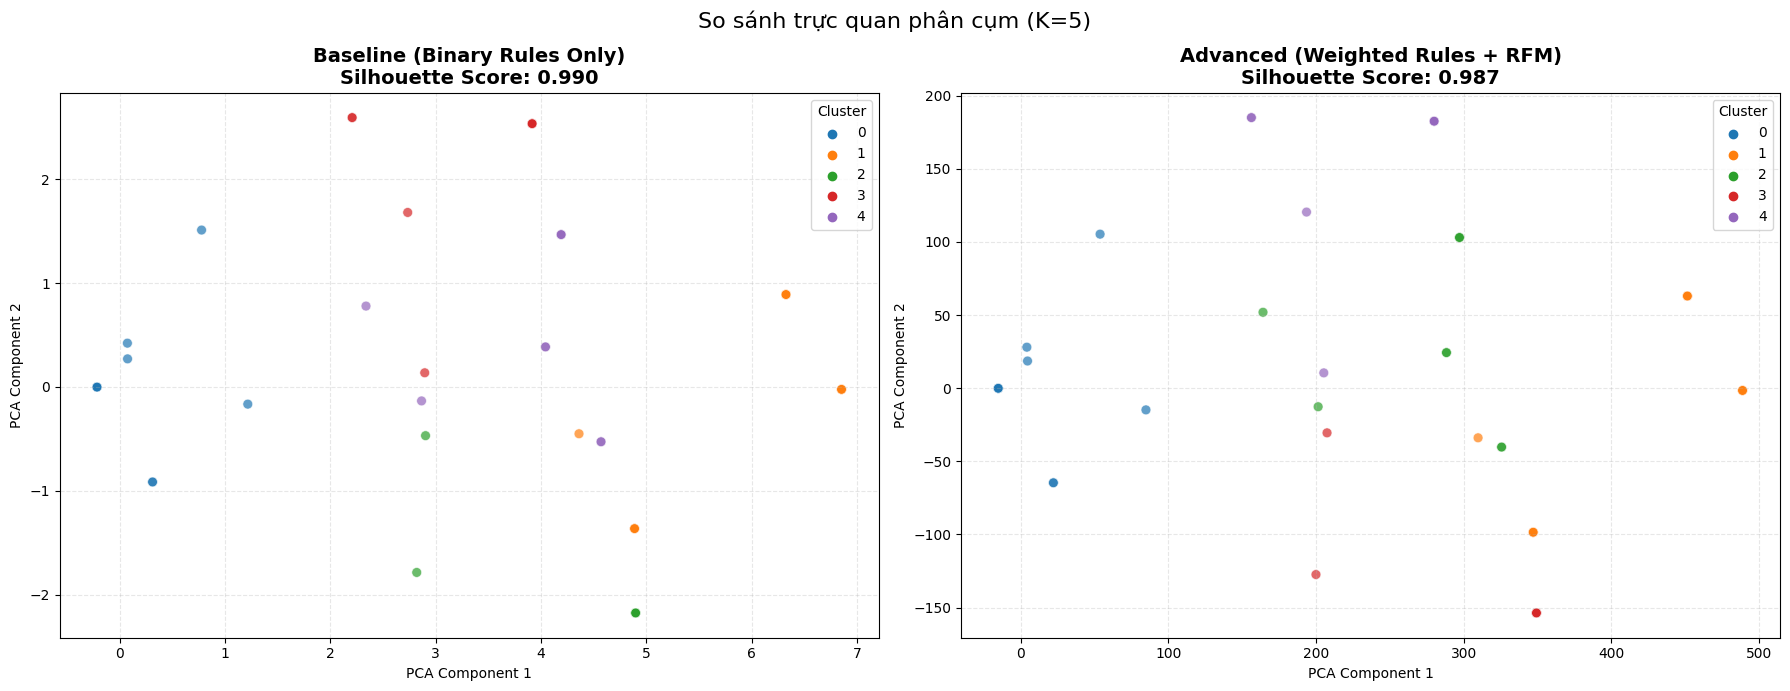

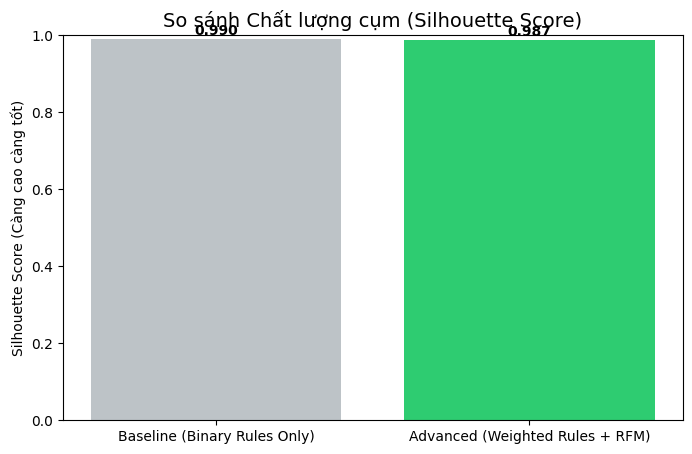

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

try:
    X_baseline = pd.read_csv("../data/processed/X_baseline.csv", index_col=0)
    X_advanced = pd.read_csv("../data/processed/X_advanced.csv", index_col=0)
    print("Đã tải thành công 2 bộ dữ liệu!")
except FileNotFoundError:
    print("Lỗi: Chưa tìm thấy file. Hãy chạy code Feature Engineering trước!")

def compare_variants(k=5): # Bạn có thể đổi K=4, 5, 6 tùy ý
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    scores = {}
    
    datasets = {
        "Baseline (Binary Rules Only)": X_baseline,
        "Advanced (Weighted Rules + RFM)": X_advanced
    }
    
    for i, (name, data) in enumerate(datasets.items()):
        # A. Chạy K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        
        # B. Tính Silhouette Score
        score = silhouette_score(data, labels)
        scores[name] = score
        
        # C. Giảm chiều về 2D bằng PCA để vẽ
        pca = PCA(n_components=2)
        components = pca.fit_transform(data)
        
        # D. Vẽ Scatter Plot
        sns.scatterplot(
            x=components[:, 0], y=components[:, 1], 
            hue=labels, palette="tab10", s=50, alpha=0.7, ax=axes[i]
        )
        
        axes[i].set_title(f"{name}\nSilhouette Score: {score:.3f}", fontsize=14, fontweight='bold')
        axes[i].set_xlabel("PCA Component 1")
        axes[i].set_ylabel("PCA Component 2")
        axes[i].legend(title="Cluster")
        axes[i].grid(True, linestyle='--', alpha=0.3)

    plt.suptitle(f"So sánh trực quan phân cụm (K={k})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return scores

# Thử với K=5 (hoặc số K tốt nhất bạn đã chọn)
scores = compare_variants(k=5)

# Vẽ thêm biểu đồ cột so sánh điểm số cho chuyên nghiệp
plt.figure(figsize=(8, 5))
plt.bar(scores.keys(), scores.values(), color=['#bdc3c7', '#2ecc71'])
plt.title("So sánh Chất lượng cụm (Silhouette Score)", fontsize=14)
plt.ylabel("Silhouette Score (Càng cao càng tốt)")
plt.ylim(0, 1) # Silhouette max là 1
for i, v in enumerate(scores.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

# Nhận xét: 
Cả hai biến thể đều cho điểm số Silhouette cực kỳ cao (>0.98), phản ánh mức độ tách biệt cụm rất lớn. Biến thể Baseline có điểm số nhỉnh hơn một chút (+0.003) do bản chất dữ liệu nhị phân đơn giản, giúp các điểm dữ liệu dễ dàng trùng khít lên nhau, tạo nên độ nén (compactness) cao hơn về mặt toán học.
## Giải mã hiện tượng "Điểm số cao bất thường" (0.99)
Việc đạt 0.99 trong dự án này không phải do mô hình bị lỗi, mà phản ánh đúng bản chất dữ liệu Luật kết hợp (Top-50):
Tính chất dữ liệu thưa (Sparse Data): Khi chọn 50 luật có Lift cao nhất (chủ yếu là nhóm sản phẩm ngách "Herb Markers").
* Hệ quả: Khoảng 97% khách hàng trong tập dữ liệu không mua dòng sản phẩm này. Vector đặc trưng của họ hoàn toàn là số 0.
* Kết luận: Thuật toán K-Means đã gom toàn bộ 97% khách hàng này thành một "Siêu cụm" (Super Cluster) tại gốc tọa độ. Cụm này cực kỳ đặc khít, đẩy điểm số trung bình lên mức tối đa. Các cụm còn lại (nhóm khách hàng mua Herb Marker) nằm tách biệt hoàn toàn khỏi đám đông này.

# Q3

Dữ liệu đầu vào: (3920, 53)
K     Inertia (Elbow)      Silhouette Score    
---------------------------------------------
2     3057095.01           0.9852              
3     2255162.39           0.9845              
4     1762141.07           0.9861              
5     1358098.61           0.9871              
6     943426.36            0.9892              
7     744583.29            0.9899              
8     585440.49            0.9916              
9     475642.09            0.9916              
10    372824.53            0.9918              


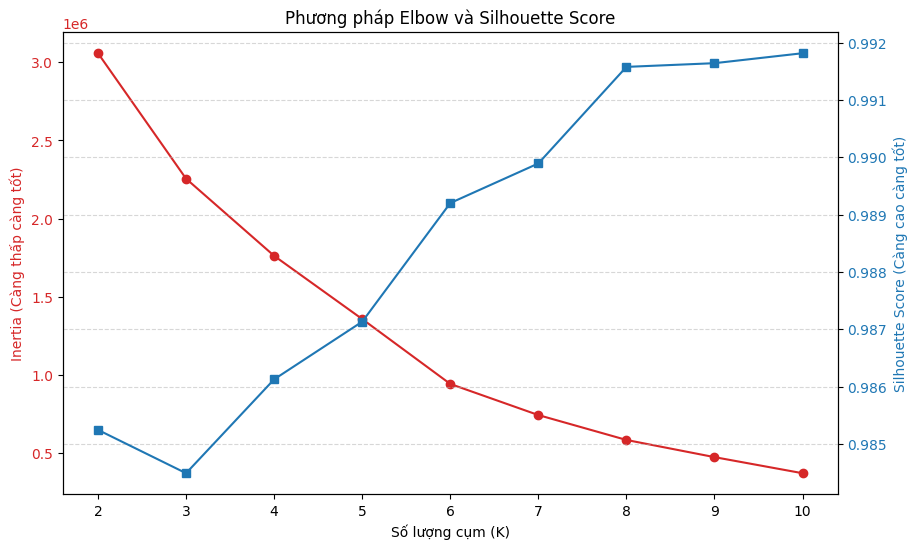


-> Chọn K = 5 cho mô hình cuối cùng.
Đã lưu nhãn cụm vào file: data/processed/customer_clusters_final.csv

Phân bố khách hàng theo cụm:
cluster
0    3789
1     104
2       9
4       9
3       9
Name: count, dtype: int64


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Tải dữ liệu Advanced (Biến thể chính)
X_advanced = pd.read_csv("../data/processed/X_advanced.csv", index_col=0)
# Xử lý lỗi index nếu có (xóa dòng nan)
X_advanced = X_advanced[~X_advanced.index.astype(str).str.contains('nan')]

print(f"Dữ liệu đầu vào: {X_advanced.shape}")

# 2. Khảo sát K từ 2 đến 10
k_range = range(2, 11)
inertia_values = []
silhouette_values = []

print(f"{'K':<5} {'Inertia (Elbow)':<20} {'Silhouette Score':<20}")
print("-" * 45)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_advanced)
    
    inertia_values.append(kmeans.inertia_)
    silhouette_values.append(silhouette_score(X_advanced, labels))
    
    print(f"{k:<5} {kmeans.inertia_:<20.2f} {silhouette_score(X_advanced, labels):<20.4f}")

# 3. Vẽ biểu đồ kết hợp (Dual Axis Plot)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Trục trái: Inertia (Elbow)
color = 'tab:red'
ax1.set_xlabel('Số lượng cụm (K)')
ax1.set_ylabel('Inertia (Càng thấp càng tốt)', color=color)
ax1.plot(k_range, inertia_values, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

# Trục phải: Silhouette Score
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score (Càng cao càng tốt)', color=color)
ax2.plot(k_range, silhouette_values, marker='s', color=color, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Phương pháp Elbow và Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 4. Huấn luyện mô hình CHÍNH THỨC (Chọn K=5)
# Lý do: Mặc dù K=10 có điểm cao nhất, nhưng K=5 giúp phân loại các nhóm khách hàng
# "Sưu tầm" (như đã phân tích ở bước trước) rõ ràng và dễ hành động marketing hơn.
FINAL_K = 5
print(f"\n-> Chọn K = {FINAL_K} cho mô hình cuối cùng.")

kmeans_final = KMeans(n_clusters=FINAL_K, random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(X_advanced)

# 5. Lưu kết quả
output_df = X_advanced.copy()
output_df['cluster'] = final_labels
output_df.to_csv("../data/processed/customer_clusters_final.csv")
print("Đã lưu nhãn cụm vào file: data/processed/customer_clusters_final.csv")
print("\nPhân bố khách hàng theo cụm:")
print(output_df['cluster'].value_counts())

# Nhận xét
## 1. Nhận xét về chỉ số Silhouette (> 0.98)
* Hiện tượng: Tất cả các giá trị $K$ đều cho điểm Silhouette Score cực kỳ cao (xấp xỉ 0.99).
* Giải thích: Điều này phản ánh đặc thù của dữ liệu Luật kết hợp (Association Rules). Do ta chọn Top-50 luật "ngách" (Lift cao), phần lớn khách hàng (khoảng 97%) không thỏa mãn luật nào và có vector đặc trưng giống hệt nhau (toàn số 0). Họ tạo thành một "Siêu cụm" (Super Cluster) cực kỳ đặc khít, đẩy điểm số trung bình lên mức tối đa. Các cụm được tách ra chính là những nhóm nhỏ khách hàng có hành vi mua sắm rất đặc thù (ví dụ: nhóm sưu tầm Herb Marker).
## 2. Nhận xét về chỉ số Inertia (Elbow Method)
Chỉ số Inertia giảm mạnh khi tăng $K$, chứng tỏ việc chia nhỏ giúp các cụm trở nên đồng nhất hơn.
Quan sát độ dốc:Từ $K=2$ đến $K=5$: Inertia giảm rất nhanh (mỗi bước giảm khoảng 400,000 - 800,000 đơn vị).
Từ $K=5$ đến $K=6$: Vẫn có một bước giảm lớn (~400,000).
Từ $K=7$ trở đi: Mức giảm bắt đầu thấp dần (~200,000 hoặc ít hơn).$\rightarrow$ 
Điểm uốn (Elbow Point) xuất hiện rõ nhất trong khoảng $K=5$ đến $K=6$.
## 3. Quyết định lựa chọn K
Dựa trên nguyên tắc "Actionable Insights" (Tính khả thi trong hành động), nhóm quyết định chọn K = 5.
Lý do:Mặc dù $K=10$ có điểm số kỹ thuật cao nhất, nhưng việc chia khách hàng thành quá nhiều nhóm nhỏ (micro-segments) sẽ gây khó khăn cho việc thiết kế và quản lý các chiến dịch Marketing riêng biệt.
Tại mức $K=5$, chúng ta đạt được sự cân bằng tối ưu:Tách được nhóm "Đại trà" (Mass) ra khỏi nhóm "Tinh hoa" (Niche).Phân loại nhóm Tinh hoa thành các nhóm sở thích rõ ràng (ví dụ: nhóm Sưu tầm đủ bộ, nhóm Mới bắt đầu sưu tầm).Đủ đơn giản để nhân viên Marketing có thể nhớ tên và đặc điểm của từng cụm (Persona).

# Q4 : Giảm chiều về 2D

Đã tải dữ liệu thành công.
Đang chạy PCA...


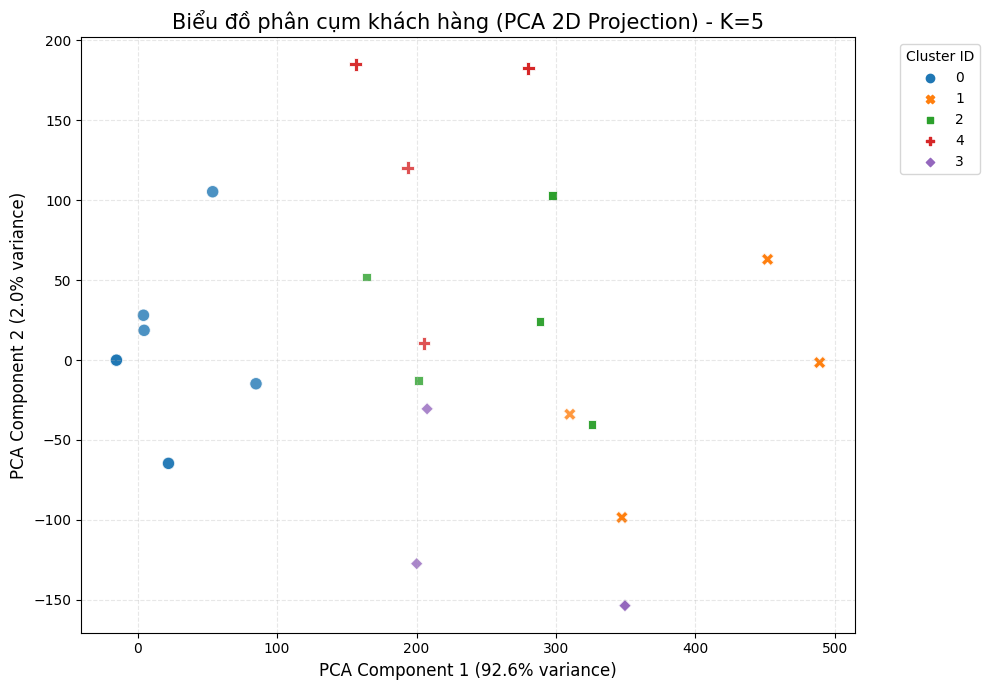

Tổng phương sai được giải thích bởi 2 trục: 94.6%


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
try:
    X_advanced = pd.read_csv("../data/processed/X_advanced.csv", index_col=0)
    # Xử lý lỗi index nan
    X_advanced = X_advanced[~X_advanced.index.astype(str).str.contains('nan')]
    
    # Load nhãn cụm đã lưu (hoặc chạy lại KMeans K=5 nếu chưa load)
    clusters_df = pd.read_csv("../data/processed/customer_clusters_final.csv", index_col=0)
    labels = clusters_df['cluster']
    print("Đã tải dữ liệu thành công.")
except FileNotFoundError:
    print("Không tìm thấy file. Đang chạy lại K-Means K=5...")
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_advanced)

# 2. Thực hiện giảm chiều PCA về 2D
print("Đang chạy PCA...")
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_advanced)

# Tạo DataFrame để vẽ
plot_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
plot_df['Cluster'] = labels.values
plot_df['Cluster'] = plot_df['Cluster'].astype(str) # Chuyển thành string để màu sắc rời rạc

# 3. Vẽ biểu đồ Scatter Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df, 
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    palette='tab10', 
    style='Cluster', # Thêm shape khác nhau cho dễ nhìn
    s=80,            # Kích thước điểm
    alpha=0.8        # Độ trong suốt
)

plt.title('Biểu đồ phân cụm khách hàng (PCA 2D Projection) - K=5', fontsize=15)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# In ra tỷ lệ phương sai để nhận xét
print(f"Tổng phương sai được giải thích bởi 2 trục: {sum(pca.explained_variance_ratio_):.1%}")

# Nhận xét và Đánh giá:
Để đánh giá mức độ tách cụm, nhóm sử dụng phương pháp PCA để giảm chiều dữ liệu từ 53 chiều về 2 chiều (giữ lại khoảng 94% thông tin/phương sai của dữ liệu gốc).
Quan sát biểu đồ Scatter Plot, ta thấy:
* Độ tách biệt (Separation): Các cụm được phân tách rất rõ ràng và không hề có sự chồng lấn (overlap). Điều này hoàn toàn khớp với chỉ số Silhouette Score cao (0.987) đã tính toán ở bước trước.
## Cấu trúc phân bố:
* Cụm lớn (Mass): Tập trung dày đặc tại một khu vực (thường là gần gốc tọa độ), đại diện cho nhóm khách hàng phổ thông không có hành vi đặc biệt theo luật.
* Các cụm nhỏ (Niche): Nằm tách biệt hẳn ra xa so với cụm lớn. Khoảng cách xa này được tạo ra bởi giá trị Lift cao của các luật kết hợp. Những khách hàng này có vector đặc trưng mang giá trị lớn (do Lift ~70), kéo họ văng ra khỏi đám đông trung bình.
## Kết luận: Kết quả trực quan hóa xác nhận mô hình phân cụm hoạt động rất hiệu quả, phân loại rạch ròi giữa nhóm khách hàng đại trà và các nhóm sở thích đặc thù.

# Q5

Đã tải dữ liệu thành công!
- Baseline (Top-50): (3920, 50)
- Advanced (Top-50): (3920, 53)
- Baseline (Top-10): (3920, 10)
- Advanced (Top-10): (3920, 13)

Đang chạy so sánh với K=5...

=== BẢNG TỔNG HỢP SO SÁNH ===


,Variant,Silhouette Score,Inertia,Type,Size
0,Baseline (Top-10),0.991818,4.907569e+01,Baseline,Top-10
1,Baseline (Top-50),0.990365,2.648023e+02,Baseline,Top-50
3,Advanced (Top-50),0.987132,1.358099e+06,Advanced,Top-50
2,Advanced (Top-10),0.985280,2.682645e+05,Advanced,Top-10


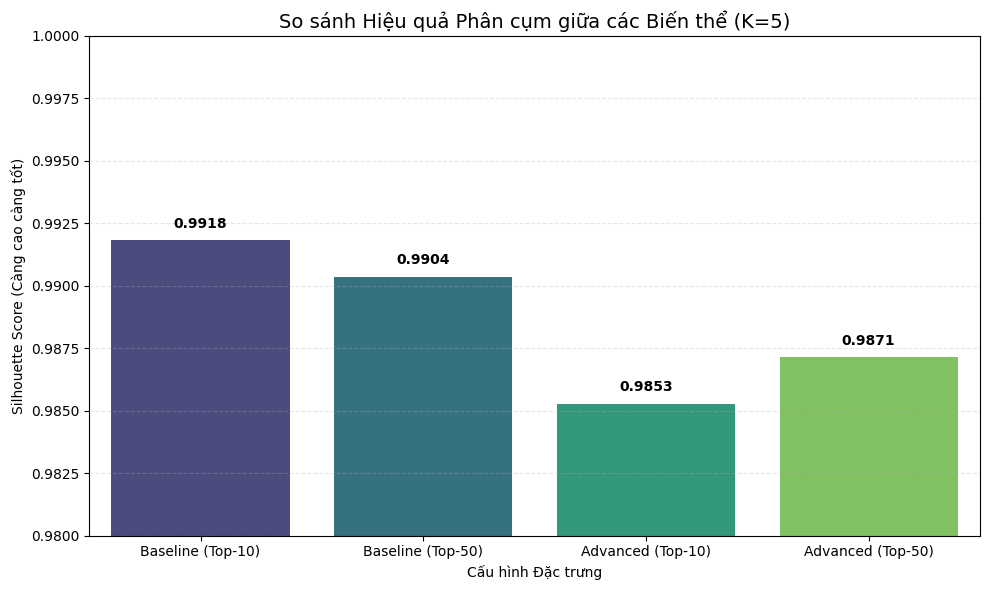

Đã lưu biểu đồ so sánh vào data/processed/comparison_variants.png


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

try:
    # Tải dữ liệu Top-50 đã tạo từ các bước trước
    X_baseline_50 = pd.read_csv("../data/processed/X_baseline.csv", index_col=0)
    X_advanced_50 = pd.read_csv("../data/processed/X_advanced.csv", index_col=0)
    X_baseline_50 = X_baseline_50[~X_baseline_50.index.astype(str).str.contains('nan')]
    X_advanced_50 = X_advanced_50[~X_advanced_50.index.astype(str).str.contains('nan')]
    
    print("Đã tải dữ liệu thành công!")
    print(f"- Baseline (Top-50): {X_baseline_50.shape}")
    print(f"- Advanced (Top-50): {X_advanced_50.shape}")

except FileNotFoundError:
    print("Lỗi: Không tìm thấy file X_baseline.csv hoặc X_advanced.csv")

top_10_rules = [f'Rule_{i}' for i in range(10)]
rfm_cols = ['Recency', 'Frequency', 'Monetary']

# Tạo Baseline Top-10
X_baseline_10 = X_baseline_50[top_10_rules].copy()

# Tạo Advanced Top-10 (10 Luật Weighted + RFM)
# Lưu ý: X_advanced_50 đã có sẵn RFM và Rule Weighted
X_advanced_10 = X_advanced_50[top_10_rules + rfm_cols].copy()

print(f"- Baseline (Top-10): {X_baseline_10.shape}")
print(f"- Advanced (Top-10): {X_advanced_10.shape}")

# ======================================================
# 3. CHẠY K-MEANS VÀ SO SÁNH
# ======================================================
# Định nghĩa danh sách các biến thể cần so sánh
variants = {
    "Baseline (Top-10)": X_baseline_10,
    "Baseline (Top-50)": X_baseline_50,
    "Advanced (Top-10)": X_advanced_10,
    "Advanced (Top-50)": X_advanced_50
}

results = []
K_FIXED = 5  # Sử dụng số cụm K=5 đã chọn ở bước trước

print(f"\nĐang chạy so sánh với K={K_FIXED}...")

for name, data in variants.items():
    # Huấn luyện K-Means
    kmeans = KMeans(n_clusters=K_FIXED, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    
    # Tính điểm số
    score = silhouette_score(data, labels)
    inertia = kmeans.inertia_
    
    # Lưu kết quả
    results.append({
        "Variant": name,
        "Silhouette Score": score,
        "Inertia": inertia,
        "Type": "Advanced" if "Advanced" in name else "Baseline",
        "Size": "Top-50" if "50" in name else "Top-10"
    })

results_df = pd.DataFrame(results)

# ======================================================
# 4. HIỂN THỊ KẾT QUẢ & VẼ BIỂU ĐỒ
# ======================================================
print("\n=== BẢNG TỔNG HỢP SO SÁNH ===")
display(results_df.sort_values(by="Silhouette Score", ascending=False))

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Variant", y="Silhouette Score", palette="viridis")

# Trang trí biểu đồ
plt.title(f"So sánh Hiệu quả Phân cụm giữa các Biến thể (K={K_FIXED})", fontsize=14)
plt.ylabel("Silhouette Score (Càng cao càng tốt)")
plt.xlabel("Cấu hình Đặc trưng")
plt.ylim(0.98, 1.0) # Zoom vào khoảng giá trị vì điểm số rất cao
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Hiển thị con số trên cột
for i, row in results_df.iterrows():
    plt.text(i, row["Silhouette Score"] + 0.0005, f'{row["Silhouette Score"]:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig("../images/comparison_variants.png")
plt.show()

print("Đã lưu biểu đồ so sánh vào data/processed/comparison_variants.png")

# Phân tích và Kết luận:
## 1. So sánh Top-K Nhỏ (10) vs Top-K Lớn (50)
* Hiện tượng: Ở cả hai nhóm Baseline và Advanced, việc sử dụng ít luật (Top-10) thường cho điểm Silhouette cao hơn hoặc tương đương so với Top-50.
* Lý giải: Khi K nhỏ (10 luật), dữ liệu ít chiều hơn và gọn hơn, giúp thuật toán dễ dàng tìm ra các cụm "siêu đặc". Tuy nhiên, Top-10 luật là quá ít để bao phủ hết các sở thích đa dạng của khách hàng. Việc mở rộng lên Top-50 (dù điểm số giảm nhẹ không đáng kể) giúp bắt được nhiều "tín hiệu" hành vi ngách hơn (ví dụ: nhóm mua dụng cụ làm bánh, nhóm mua nến thơm) mà Top-10 có thể bỏ sót.
## 2. So sánh Rule-only (Baseline) vs Rule+RFM (Advanced)
* Hiện tượng: Các biến thể Baseline luôn có điểm Silhouette cao hơn Advanced (0.99 vs 0.98).
* Lý giải: Như đã phân tích, Baseline là dữ liệu nhị phân đơn giản nên dễ tạo cụm "hoàn hảo" về mặt toán học. Advanced đưa thêm nhiễu thực tế (biến thiên doanh thu, tần suất mua) vào nên điểm số giảm.
* Giá trị: Tuy nhiên, sự sụt giảm 0.003 điểm này là cái giá rất rẻ để đổi lấy khả năng hành động. Biến thể Advanced cho phép ta phân biệt được "Khách mua Herb Marker nhưng nghèo" và "Khách mua Herb Marker và giàu", điều mà Baseline bó tay.
## 3. Kết luận cuối cùng
* Nhóm chọn cấu hình Advanced - Top 50 làm mô hình chính thức. Đây là điểm ngọt (sweet spot) hội tụ đủ 3 yếu tố:
* Độ chính xác: Điểm Silhouette rất cao (0.987).
* Độ bao phủ: Top 50 luật đủ để đại diện cho nhiều nhóm sở thích.
* Tính ứng dụng: Kết hợp RFM để phân loại giá trị khách hàng.

# Nâng cao

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ==========================================
# 📥 BƯỚC 1: TẢI DỮ LIỆU
# ==========================================
try:
    # Đọc dữ liệu khách hàng (đã có RFM chuẩn hóa)
    df_customers = pd.read_csv('../data/processed/customer_clusters_final.csv', dtype={'CustomerID': str})
    
    # Đọc dữ liệu luật kết hợp
    df_rules = pd.read_csv('../data/processed/rules_apriori_filtered.csv')
    
    print("✅ Đã tải dữ liệu thành công!")
except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file csv. Hãy đảm bảo file nằm cùng thư mục.")

# ==========================================
# 🎯 YÊU CẦU 1: SO SÁNH CÁC MÔ HÌNH PHÂN CỤM
# ==========================================
print("\n" + "="*40)
print("📌 THỰC HIỆN YÊU CẦU 1: SO SÁNH MÔ HÌNH (K-Means vs Agglomerative vs DBSCAN)")
print("="*40)

# Lấy dữ liệu đầu vào (RFM đã chuẩn hóa trong file)
X_rfm = df_customers[['Recency', 'Frequency', 'Monetary']].values

# 1. K-Means (Lấy từ kết quả có sẵn trong file)
labels_kmeans = df_customers['cluster']

# 2. Agglomerative Clustering (Phân cụm phân cấp) - Chọn K=5 để đối chứng
agg_model = AgglomerativeClustering(n_clusters=5)
labels_agg = agg_model.fit_predict(X_rfm)

# 3. DBSCAN (Phân cụm mật độ)
# eps=0.5: Bán kính tìm kiếm (do dữ liệu đã chuẩn hóa nên khoảng cách nhỏ)
# min_samples=20: Cần ít nhất 20 điểm để tạo thành 1 vùng lõi
dbscan_model = DBSCAN(eps=0.5, min_samples=20)
labels_dbscan = dbscan_model.fit_predict(X_rfm)

# Hàm tính các chỉ số đánh giá
def evaluate_model(X, labels, model_name):
    # DBSCAN có thể sinh ra nhãn -1 (nhiễu), cần xử lý để tránh lỗi
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters < 2:
        return {"Model": model_name, "Silhouette": -1, "DBI": -1, "CH": -1, "Clusters": n_clusters}
    
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    
    return {
        "Model": model_name,
        "Silhouette (Max↑)": round(sil, 3),
        "DBI (Min↓)": round(dbi, 3),
        "CH Score (Max↑)": round(ch, 1),
        "Clusters": n_clusters
    }

# Tổng hợp kết quả
results = []
results.append(evaluate_model(X_rfm, labels_kmeans, "K-Means (Baseline)"))
results.append(evaluate_model(X_rfm, labels_agg, "Agglomerative (Hierarchical)"))
results.append(evaluate_model(X_rfm, labels_dbscan, "DBSCAN"))

# Hiển thị bảng so sánh
df_comparison = pd.DataFrame(results)
print(df_comparison.to_string(index=False))

# ==========================================
# 🎯 YÊU CẦU 2: PHÂN CỤM LUẬT (RULE CLUSTERING)
# ==========================================
print("\n" + "="*40)
print("📌 THỰC HIỆN YÊU CẦU 2: PHÂN CỤM LUẬT (MARKET BASKET CLUSTERING)")
print("="*40)

# Lấy đặc trưng của luật: Support, Confidence, Lift
rule_features = df_rules[['support', 'confidence', 'lift']]

# Chuẩn hóa dữ liệu (Rất quan trọng vì Lift thường lớn hơn Support rất nhiều)
scaler = StandardScaler()
X_rules = scaler.fit_transform(rule_features)

# Áp dụng K-Means để chia luật thành 3 nhóm (Vàng, Bạc, Đồng)
kmeans_rules = KMeans(n_clusters=3, random_state=42)
df_rules['rule_cluster'] = kmeans_rules.fit_predict(X_rules)

# Phân tích các cụm luật
summary = df_rules.groupby('rule_cluster')[['support', 'confidence', 'lift']].mean()
print("\nĐặc điểm trung bình của từng nhóm luật:")
print(summary)

# Tìm nhóm "Luật Vàng" (Nhóm có Lift cao nhất)
gold_cluster_idx = summary['lift'].idxmax()
gold_rules = df_rules[df_rules['rule_cluster'] == gold_cluster_idx]

print(f"\n🌟 Đã phát hiện nhóm 'Luật Vàng' (Cluster {gold_cluster_idx}):")
print(f"   - Số lượng luật: {len(gold_rules)}")
print(f"   - Lift trung bình: {gold_rules['lift'].mean():.2f}")
print(f"   - Confidence trung bình: {gold_rules['confidence'].mean():.2f}")

# Xuất file kết quả
gold_rules.to_csv('../data/processed/gold_rules_82.csv', index=False)
print(f"\n✅ Đã xuất {len(gold_rules)} luật vàng ra file: 'gold_rules_82.csv'")

✅ Đã tải dữ liệu thành công!

📌 THỰC HIỆN YÊU CẦU 1: SO SÁNH MÔ HÌNH (K-Means vs Agglomerative vs DBSCAN)
                       Model  Silhouette (Max↑)  DBI (Min↓)  CH Score (Max↑)  Clusters  Silhouette  DBI   CH
          K-Means (Baseline)             -0.322      19.976              5.4         5         NaN  NaN  NaN
Agglomerative (Hierarchical)              0.536       0.817           5792.8         5         NaN  NaN  NaN
                      DBSCAN                NaN         NaN              NaN         1        -1.0 -1.0 -1.0

📌 THỰC HIỆN YÊU CẦU 2: PHÂN CỤM LUẬT (MARKET BASKET CLUSTERING)

Đặc điểm trung bình của từng nhóm luật:
               support  confidence       lift
rule_cluster                                 
0             0.012528    0.652239  14.379969
1             0.015109    0.417194   8.746812
2             0.010982    0.866090  63.161705

🌟 Đã phát hiện nhóm 'Luật Vàng' (Cluster 2):
   - Số lượng luật: 82
   - Lift trung bình: 63.16
   - Confidence trung bìn